## Python Frontend for Suspect Analysis Project

In [2]:
#Installs
%pip install tk
%pip install ttkthemes
%pip install pillow
%pip install torch
%pip install torchvision
%pip install matplotlib
%pip install pdfkit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Dominik Danda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Dominik Danda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Dominik Danda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Dominik Danda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Dominik Danda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Dominik Danda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Dominik Danda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
#Imports
from tkinter import *
from tkinter import ttk
from tkinter import filedialog
from ttkthemes import ThemedTk
from PIL import Image, ImageTk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy
from reportlab.lib.pagesizes import letter, landscape, A2
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as ReportLabImage, Table, Frame, Flowable, BaseDocTemplate, PageTemplate, FrameBreak


In [4]:
#generator
label_length = 16
class generator(nn.Module): 
    def __init__(self):
        super(generator,self).__init__()
        #linear layer
        self.fc1 = nn.Linear(label_length,16*16*128)
        
        self.convinv1 = nn.ConvTranspose2d(128,64,kernel_size = 4, stride = 2, padding = 1, bias = True) #128*16*16 -> 64*32*32
        self.convinv2 = nn.ConvTranspose2d(64,64,kernel_size = 4, stride = 2, padding = 1, bias = True) #64*32*32 -> 64*64*64
        self.convinv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias = True) #64*64*64 -> 128*128*32
        self.convpreserve2 = nn.Conv2d(32,32,kernel_size = 5, stride = 1, padding = 2, bias = True) #128*128*32 -> 128*128*32
        self.convinv4 = nn.Conv2d(32,3,kernel_size = 1, stride = 1, padding= 0, bias = True) #128*128*64 -> 128*128*3
    
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x))
        x = x.view(-1, 128,16,16)
        x = F.leaky_relu(self.convinv1(x))
        x = F.leaky_relu(self.convinv2(x))
        x = F.leaky_relu(self.convinv3(x))
        x = F.leaky_relu(self.convpreserve2(x))
        
        x = self.convinv4(x)
        
        return x
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [5]:
#classifier
class primary_net(nn.Module):
    def __init__(self):
        super(primary_net, self).__init__()
        #convolutional
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias = True) #128*128*3 -> 128*128*64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias = True) #128*128*64 -> 64*64*64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias = True) #64*64*64 -> 64*64*128
        self.pool1 = nn.AvgPool2d(kernel_size=4, stride=4) #64*64*128 -> 16*16*128
        #self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias = True) #32*32*128 -> 32*32*256
        #self.conv5 = nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=1, bias = True) #32*32*256 -> 16*16*256
        #self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #16*16*256 -> 8*8*256

        #classifier
        self.fc1 = nn.Linear(16*16*128, 16, bias = True)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv3(F.relu(self.conv2(F.relu(self.conv1(x)))))))
        #x = self.pool2(F.relu(self.conv5(F.relu(self.conv4(x)))))
        x = x.view(-1, 16*16*128)
        x = self.fc1(x)
        #x = self.fc2(x)
        return x

In [6]:
# Instantiate the networks
classifier = primary_net()
gen = generator()

# Load the weights
classifier_weights_path = 'modelArchitectures/model_primary_net_bs256_lr0.001_epoch594'
generator_weights_path = 'modelArchitectures/generatorbest.pth'

classifier.load_state_dict(torch.load(classifier_weights_path, map_location=torch.device('cpu')))
gen.load_state_dict(torch.load(generator_weights_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:



def browse_folder_button():
    filename = filedialog.askdirectory()
    global folder_path
    global folder_path_short
    folder_path.set(filename)
    folder_path_short.set(shorten_path(filename))
    return folder_path

def browse_file_button():
    filename = filedialog.askopenfilename(filetypes=[("JPG files", "*.jpg")])
    global file_path
    global file_path_short
    file_path.set(filename)
    file_path_short.set(shorten_path(filename))
    global img, pic, image_label
    img = Image.open(file_path.get())
    img = img.resize((128, 128))
    pic = ImageTk.PhotoImage(img)

    image_label.config(image=pic)
    image_label.image = pic
    return file_path

def generate_attribute_array(attribute_list):
    # Attribute list: Bald, Big Lips, Big Nose, Black Hair, Blond Hair, Brown Hair, Chubby, Gray Hair, Male, 
    #                 No Beard, Pale Skin, Pointy Nose, Receding Hairline, Straight Hair, Wavy Hair, Young
    
    # Attribute array is a 2d string array that stores the final pdf table, similar attributs should be grouped, i.e hair color, hair style, etc.
    
    attribute_array = []
    
    # The input attribute list is a float list, do thresholding to append attributes to the attribute array
    
    # find the hair color with the highest probability, then add it to the attribute array
    
    hair_colors = ["Black Hair", "Blond Hair", "Brown Hair", "Gray Hair"]
    hair_list = [attribute_list[3], attribute_list[4], attribute_list[5], attribute_list[7]]
    max_index = hair_list.index(max(hair_list))
    hair_color = []
    hair_color.append("Hair Color:")
    hair_color.append(hair_colors[max_index])
    attribute_array.append(hair_color)
    
    # find the hair style with the highest probability, then add it to the attribute array
    
    hair_styles = ["Bald", "Receding Hairline", "Straight Hair", "Wavy Hair"]
    hair_style_list = [attribute_list[0], attribute_list[12], attribute_list[13], attribute_list[14]]
    max_index = hair_style_list.index(max(hair_style_list))
    hair_style = []
    hair_style.append("Hair Style:")
    hair_style.append(hair_styles[max_index])
    attribute_array.append(hair_style)
    
    
    # Facial features
    facial_features = []
    feature_string = ""
    facial_features.append("Facial Features:")
    if attribute_list[1] > 0.7:
        feature_string += "Big Lips\n"
    if attribute_list[1] <= 0.7 and attribute_list[1] > 0.3:
        feature_string += "Medium Lips\n"
    if attribute_list[1] <= 0.3:
        feature_string += "Small Lips\n"
    
    if attribute_list[2] > 0.7:
        feature_string +=  "Big Nose\n"
    if attribute_list[2] <= 0.7 and attribute_list[2] > 0.3:
        feature_string +=  "Medium Nose\n"
    if attribute_list[2] <= 0.3:
        feature_string +=  "Small Nose\n"
    
    if attribute_list[10] > 0.7:
        feature_string += "Pale Skin\n"
    if attribute_list[10] <= 0.7 and attribute_list[10] > 0.3:
        feature_string += "Medium Skin\n"
    if attribute_list[10] <= 0.3:
        feature_string += "Rich Skin\n"
    
    if attribute_list[11] > 0.5:
        feature_string +=  "Pointy Nose\n"
    if attribute_list[11] <= 0.5:
        feature_string += "Round Nose\n"
        
    
    if attribute_list[9] > 0.5:
        feature_string += "No Beard\n"
    else:
        feature_string += "Beard\n"
    
    facial_features.append(feature_string)
    if len(facial_features) > 0:
        attribute_array.append(facial_features)
    
    weight = []
    weight.append("Weight:")
    if attribute_list[6] > 0.7:
        weight.append("Chubby")
    elif attribute_list[6] <= 0.7 and attribute_list[6] > 0.3:
        weight.append("Average")
    else:
        weight.append("Slim")
    
    sex = []
    sex.append("Sex:")
    if attribute_list[8] > 0.5:
        sex.append("Male")
    else:
        sex.append("Female")
    attribute_array.append(sex)
    
    age = []
    age.append("Age:")
    if attribute_list[15] > 0.5:
        age.append("Young")
    else:
        age.append("Old")
    attribute_array.append(age)
    
    return attribute_array

def generate_wanted_poster(output_image_path, save_path, attribute_list):
    # Create a PDF document
    doc = SimpleDocTemplate(save_path, pagesize=[419.58, 595.35], rightMargin=15, leftMargin=15, topMargin=15, bottomMargin=18)
    
    # Create a list of flowables
    flowables = []
    
    # Add red bold title in an interesting font
    title_style = getSampleStyleSheet()["Title"]
    title_style.textColor = colors.red
    title_style.fontSize = 72
    title = Paragraph("WANTED", title_style)
    flowables.append(title)
    
    # Add a spacer
    flowables.append(Spacer(1, 48))
    
    # Add the image
    image = ReportLabImage(output_image_path, width=3.25*inch, height=3.25*inch)
    flowables.append(image)
    
    # Add the attribute table with all text pushed to the top of each cell and the table has outlines for all cells, and a thick outer border
    attribute_array = generate_attribute_array(attribute_list)
    attribute_table = Table(attribute_array, style=[('VALIGN', (0,0), (-1,-1), 'TOP'), ('GRID', (0,0), (-1,-1), 1, colors.black), ('BOX', (0,0), (-1,-1), 2, colors.black)])
    flowables.append(attribute_table)
    
    # Add a spacer
    flowables.append(Spacer(1, 24))
    
    
    # Add some text at the bottom which randomly selects a crime with "last seen" and "reward" information
    crime = ["Arson", "Assault", "Burglary", "DUI", "Fraud", "Homicide", "Kidnapping", "Robbery", "Theft", "Vandalism"]
    last_seen = ["In the vicinity of the local bank", "At the local bar", "At the local casino", "At the local church", "At the local courthouse", "At the local hospital", "At the local library", "At the local park", "At the local police station", "At the local post office"]
    reward = ["$5000", "$10000", "$50000", "$100000", "$500000", "$1000000", "$5000000"]
    
    # Put each piece of information on a new line
    crime_text = "Crime: " + numpy.random.choice(crime)
    last_seen_text = "Last Seen: " + numpy.random.choice(last_seen)
    reward_text = "Reward: " + numpy.random.choice(reward)
    
    # Create a paragraph with the text and center it
    title_style = getSampleStyleSheet()["Title"]
    title_style.textColor = colors.black
    title_style.fontSize = 16
    crime_paragraph = Paragraph(crime_text + "<br/>" + last_seen_text + "<br/>" + reward_text, title_style)
    flowables.append(crime_paragraph)
    
    
    
    # build the document
    doc.build(flowables)

#FIX HERE!!! -> DONE
def analyze_button():
    log_messages = ""

    # Check if the folder and file paths are selected
    if not folder_path.get() or folder_path.get() == "No Folder Selected":
        log_messages += "Error: No folder selected.\n"
        
    if not file_path.get() or file_path.get() == "No File Selected":
        log_messages += "Error: No file selected.\n"

    # If there are no errors, proceed with the analysis
    if log_messages == "":  # This means no errors
        log_messages = "Success: Analysis started..."
        transform1 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((128,128)),
        ])

        with open(file_path.get(), 'rb'):
            img1 = plt.imread(file_path.get())
            img1 = transform1(img1[1:])

        label_float = classifier(img1)
        label = F.sigmoid(label_float)
        print(label.tolist())
        output = gen(label)
        output = output.squeeze(0)
        output = output.permute(1,2,0)
        image_np = output.detach().numpy()

        plt.axis('off')
        plt.imshow(image_np, aspect="auto")
        output_image_path = os.path.join(folder_path.get(), "imgoutput.png")
        plt.savefig(output_image_path)

        pdf_save_path = os.path.join(folder_path.get(), "WANTED_poster.pdf")
        generate_wanted_poster(output_image_path, pdf_save_path, label.squeeze(0).tolist())

        log_messages += "\nWANTED poster saved at " + pdf_save_path


    log_var.set(log_messages)

#function to make filepath shorter
def shorten_path(path, max_length=20):
    # Get the file name from the path
    file_name = os.path.basename(path)
    
    # If the file name is longer than max_length, shorten it and add "..."
    if len(file_name) > max_length:
        return file_name[:max_length - 2] + "..."
    else:
        return file_name


[[4.667052417062223e-05, 0.4444795250892639, 0.8937283754348755, 0.016605686396360397, 7.472019092347182e-08, 0.06390028446912766, 0.7518371343612671, 3.94569451600546e-06, 0.9999872446060181, 0.3193526864051819, 0.0008170934743247926, 0.05254054442048073, 4.04327556680073e-06, 0.215852290391922, 0.027492200955748558, 0.34443655610084534]]


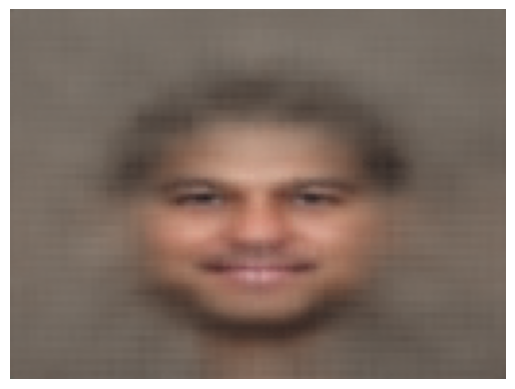

: 

In [12]:
root = ThemedTk(theme="equilux")
root.resizable(False, False)
root.title("Suspect Analysis")

img = ImageTk.PhotoImage(Image.open("BlankImage.png"))

folder_path = StringVar()
folder_path_short = StringVar()
folder_path_short.set("No Folder Selected") # path to the folder the user selects

file_path = StringVar()
file_path_short = StringVar()
file_path_short.set("No File Selected") # path to the file the user selects

log_var = StringVar()  # for messages
log_var.set("Errors and Status Messages will appear here.")

frm = ttk.Frame(root, padding=25)
frm.grid(row=0, column=0, sticky="nsew")
frm.grid_columnconfigure(0, weight=1)
frm.grid_rowconfigure(0, weight=1)
frm.grid_rowconfigure(1, weight=1)
frm.grid_rowconfigure(2, weight=1)


button_frame1 = ttk.Frame(frm, padding=10, relief="sunken", borderwidth=2)
button_frame1.grid(row=0, column=0, columnspan=2, sticky="nsew")
button_frame1.grid_columnconfigure(0, weight=1)
button_frame1.grid_columnconfigure(1, weight=1)

# button frame
button_frame2 = ttk.Frame(button_frame1, padding=10)
button_frame2.grid(row=0, column=0, sticky="nsew")
button_frame2.grid_columnconfigure(0, weight=1)

# image frame
image_frame = ttk.Frame(button_frame1, padding=20)
image_frame.grid(row=0, column=2, sticky="nsew") #north south east west poisitons on the widget
image_frame.grid_rowconfigure(0, weight=1)
image_frame.grid_columnconfigure(0, weight=1)

separator = ttk.Separator(button_frame1, orient='vertical')
separator.grid(row=0, column=1, sticky='ns', padx=5)

LABEL_WIDTH = 30
ttk.Label(button_frame2, textvariable=folder_path_short, width = LABEL_WIDTH, anchor = "w").grid(column=0, row=0, sticky="w", pady=(0, 5))
ttk.Button(button_frame2, text="Select Folder", command=browse_folder_button).grid(column=0, row=1, sticky="ew", pady=(0, 10))

ttk.Label(button_frame2, textvariable=file_path_short, width = LABEL_WIDTH, anchor = "w").grid(column=0, row=2, sticky="w", pady=(0, 5))
ttk.Button(button_frame2, text="Select Image", command=browse_file_button).grid(column=0, row=3, sticky="ew", pady=(0, 5))

ttk.Button(button_frame2, text="Analyze", command=analyze_button).grid(column=0, row=4, sticky="ew", pady=(0, 10))

ttk.Button(button_frame2, text="Quit", command=root.destroy).grid(column=0, row=5, sticky="ew")

image_label = ttk.Label(image_frame, image=img)
image_label.im = img
image_label.grid(column=0, row=0, sticky="nsew")

log_frame = ttk.Frame(frm, padding=10, relief="sunken", borderwidth=2)
log_frame.grid(row=1, column=0, columnspan=2, sticky="nsew")

log_label = ttk.Label(log_frame, textvariable=log_var)
log_label.grid(column=0, row=0, sticky="nsew")

root.mainloop()